In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#  1. Linear classifier for CIFAR10

In [24]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)
print('y_train:',y_train.shape)
print('x_test:',x_test.shape)
print('y_test:',y_test.shape)

K = len(np.unique(y_train)) # Classes
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10
print('Classes K:',K)

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)
Classes K: 10


- np.unique - Returns the sorted unique elements of an array

In [25]:
# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train: ', x_train.shape)
print('y_train: ',y_train.shape)
print('x_test: ',x_test.shape)
print('y_test: ',y_test.shape)

x_train:  (50000, 3072)
y_train:  (50000, 10)
x_test:  (10000, 3072)
y_test:  (10000, 10)


- np.mean - Compute the arithmetic mean along the specified axis
- tf.keras.utils.to_categorical - converts a class vector (integers) to binary class matrix

In [26]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda

### Definitions

In [27]:
#loss function
def Loss(y_pred,y,w1,w2=0):
    batch_size = y_pred.shape[0]
    loss = (1/batch_size)*(np.square(y-y_pred)).sum() + reg*(np.sum(w1*w1)+np.sum(w2*w2))
    return loss

In [28]:
#accuracy function
def Accuracy(y_pred,y):
    batch_size = y_pred.shape[0]
    K = y_pred.shape[1]
    acc = 1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [29]:
#linear classifier model
def LinearCls(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    std = 1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    loss_history = []
    tst_loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations):
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x = x_train[indices]
        y = y_train[indices]

        #forward pass
        y_pred = x.dot(w1)+b1
        y_pred_tst = x_test.dot(w1)+b1

        train_loss = Loss(y_pred,y,w1)
        loss_history.append(train_loss)
        test_loss = Loss(y_pred_tst,y_test,w1)
        tst_loss_history.append(test_loss)
        train_acc = Accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc = Accuracy(y_pred_tst,y_test)
        val_acc_history.append(test_acc)

        if t%10==0:
            print('iteration %d / %d: Train loss = %f , Test loss = %f , Train accuracy = %f , Test accuracy = %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred = (1./batch_size)*2.0*(y_pred-y)  #partial derivative of L w.r.t. y_pred
        dw1 = x.T.dot(dy_pred)+reg*w1
        db1 = dy_pred.sum(axis=0)
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,tst_loss_history,train_acc_history,val_acc_history

- np.random.randn - Return a sample (or samples) from the “standard normal” distribution

In [30]:
w1,b1,loss_history,tst_loss_history,train_acc_history,val_acc_history = LinearCls(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

iteration 0 / 300: Train loss = 0.999974 , Test loss = 0.999972 , Train accuracy = 0.684562 , Test accuracy = 0.684560
iteration 10 / 300: Train loss = 0.876638 , Test loss = 0.876235 , Train accuracy = 0.756504 , Test accuracy = 0.758080
iteration 20 / 300: Train loss = 0.842541 , Test loss = 0.842416 , Train accuracy = 0.762656 , Test accuracy = 0.767580
iteration 30 / 300: Train loss = 0.823616 , Test loss = 0.823713 , Train accuracy = 0.766486 , Test accuracy = 0.770610
iteration 40 / 300: Train loss = 0.812389 , Test loss = 0.812705 , Train accuracy = 0.768694 , Test accuracy = 0.771570
iteration 50 / 300: Train loss = 0.805426 , Test loss = 0.805968 , Train accuracy = 0.770366 , Test accuracy = 0.772850
iteration 60 / 300: Train loss = 0.800905 , Test loss = 0.801677 , Train accuracy = 0.771572 , Test accuracy = 0.773350
iteration 70 / 300: Train loss = 0.797821 , Test loss = 0.798822 , Train accuracy = 0.772698 , Test accuracy = 0.773570
iteration 80 / 300: Train loss = 0.795605

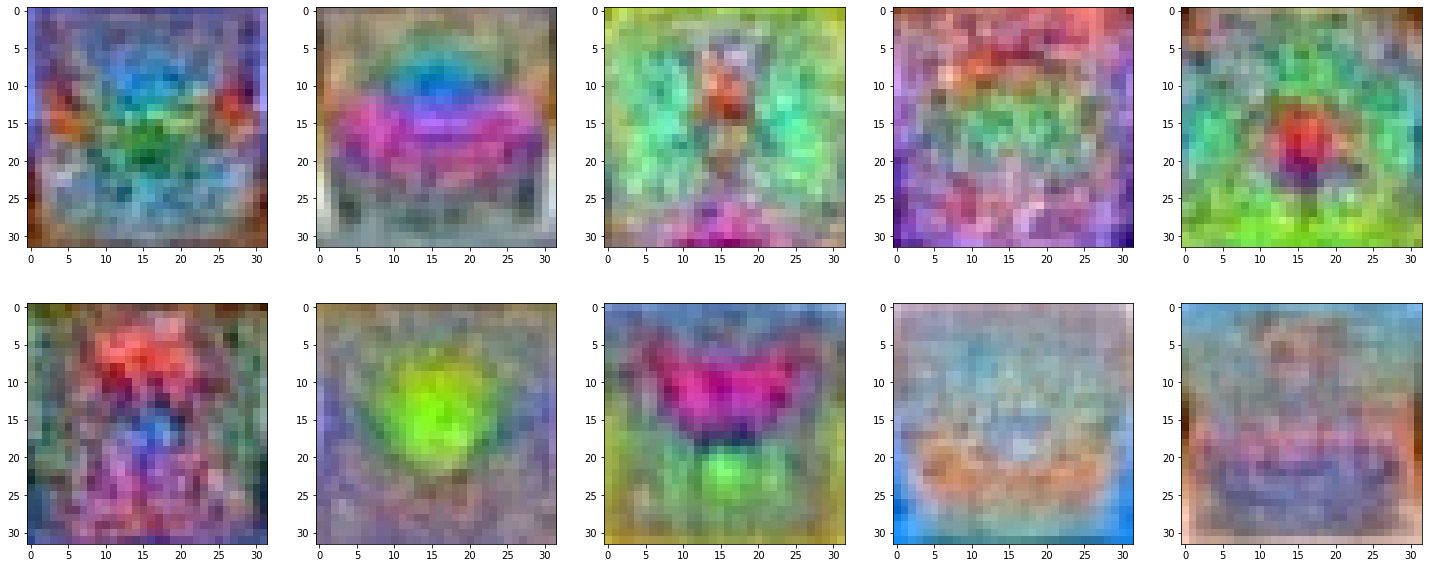

In [31]:
import cv2 as cv
img = []
for i in range(w1.shape[1]):
    im = np.reshape(w1[:,i]*255,(32,32,3))
    im = cv.normalize(im, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)   #normalize the values
    img.append(im)
fig,ax = plt.subplots(2,5,figsize=(25,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(img[i*5+j],vmin=0,vmax=255)
plt.show()

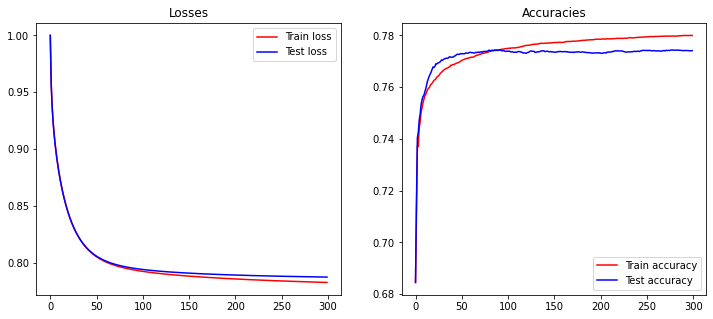

In [34]:
#plotting losses and accuracies
fig, axes  = plt.subplots(1,2, figsize=(12,5))

axes[0].plot(loss_history,color="r")
axes[0].plot(tst_loss_history,color="b")
axes[0].set_title('Losses')
axes[0].legend(['Train loss','Test loss'])

axes[1].plot(train_acc_history,color="r")
axes[1].plot(val_acc_history,color="b")
axes[1].set_title('Accuracies')
axes[1].legend(['Train accuracy','Test accuracy'])